# 1. Get building polygons from OpenStreetMap

## Training area - Limehouse, London
Intially the area I'm using is a section of Limehouse, London. I've chosen this area as the building polygons for terraced houses are accurate and well defined with each house being a single polygon rather than a large connected rectangle. It is also an inner city area with a high density of buildings which will be useful for training and closer to the city typology of the wider Tower Hamlets borough which we will eventually be classifying.

Below is a screenshot of this area on OpenStreetMap.

<p style='text-align: center;'>
    <img src="./data/london/raw-inputs/Limehouse_OSM_Screenshot.png" alt="Limehouse OpenStreetMap Screenshot" width="860"/>
</p>

## Define constants and generate file paths
We'll be using slippy map tiles of `TILE_SIZE = 512` and `ZOOM_LEVEL = 19` which is a good balance between image resolution and processing time for the number of tiles. I'm determine the location to scan from using `LATITUDE_TOP`, `LONGITUDE_LEFT`, `LATITUDE_BOTTOM`, and `LONGITUDE_RIGHT`. These are the boundaries of the area we want to export from [OpenStreetMap](https://www.openstreetmap.org/export#map=17/51.51470/-0.03502) which will be used to extract the building footprints.

First let's import the required libraries and define the constants.

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path
import random
import os
import mercantile
import geopandas as gpd
import rasterio
import solaris as sol
import requests
import shutil
import json
from typing import List, Tuple, Dict
from dotenv import load_dotenv

In [56]:
TILE_SIZE = 512
ZOOM_LEVEL = 19
LATITUDE_TOP = 51.51802
LATITUDE_BOTTOM = 51.51239
LONGITUE_LEFT = -0.04105
LONGITUE_RIGHT = -0.03188

# Load .env file
load_dotenv()

# First create a data directory and subdirectories for images and masks
DATA_DIR = Path('./data/london/')
DATA_DIR.mkdir(exist_ok=True)

# Create subdirectory for tile size (s) and zoom level (z)
IMAGE_PATH = DATA_DIR / 'images'
IMAGE_PATH.mkdir(exist_ok=True)

MASKS_PATH = DATA_DIR / 'masks'
MASKS_PATH.mkdir(exist_ok=True)

POLYGONS_PATH = DATA_DIR / 'polygons'
POLYGONS_PATH.mkdir(exist_ok=True)

# Create tile size (s) and zoom level (z) subdirectories within images and masks
(IMAGE_PATH / f's{TILE_SIZE}_z{ZOOM_LEVEL}').mkdir(exist_ok=True)
(MASKS_PATH / f's{TILE_SIZE}_z{ZOOM_LEVEL}').mkdir(exist_ok=True)

# Create training and validation subdirectories within images and masks
(IMAGE_PATH / f's{TILE_SIZE}_z{ZOOM_LEVEL}' / 'train').mkdir(exist_ok=True)
(IMAGE_PATH / f's{TILE_SIZE}_z{ZOOM_LEVEL}' / 'validation').mkdir(exist_ok=True)

(MASKS_PATH / f's{TILE_SIZE}_z{ZOOM_LEVEL}' / 'train').mkdir(exist_ok=True)
(MASKS_PATH / f's{TILE_SIZE}_z{ZOOM_LEVEL}' / 'validation').mkdir(exist_ok=True)

## Create a geoJSON bounding box
We will use the `LATITUDE_TOP`, `LONGITUDE_LEFT`, `LATITUDE_BOTTOM`, and `LONGITUDE_RIGHT` to create a GeoJSON bounding box which we can use to extract the building footprints from the OpenStreetMap export.

<AxesSubplot:>

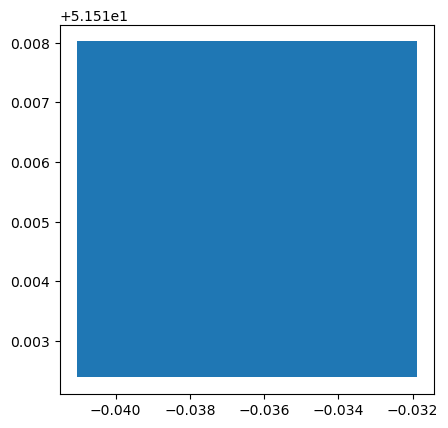

In [57]:
bounding_box_geojson = {
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "properties": {},
            "geometry": {
                "coordinates": [
                    [
                        [
                            LONGITUE_LEFT,
                            LATITUDE_TOP
                        ],
                        [
                            LONGITUE_LEFT,
                            LATITUDE_BOTTOM
                        ],
                        [
                            LONGITUE_RIGHT,
                            LATITUDE_BOTTOM
                        ],
                        [
                            LONGITUE_RIGHT,
                            LATITUDE_TOP
                        ],
                        [
                            LONGITUE_LEFT,
                            LATITUDE_TOP
                        ]
                    ]
                ],
                "type": "Polygon"
            }
        }
    ]
}

# Save the bounding box geojson
with open(POLYGONS_PATH / 'limehouse.geojson', 'w') as f:
    json.dump(bounding_box_geojson, f)

# Create a geodataframe from the bounding box geojson
bounding_box_gdf = gpd.read_file(POLYGONS_PATH / 'limehouse.geojson')
bounding_box_gdf.plot()

## Generate slippy map tile polygons using supermercado and geopandas

Next we'll use [`supermercado`](https://github.com/mapbox/supermercado) to generate square polygons representing each slippy map satellite image tile. We'll specify a zoom level and make use of the geoJSON bounding box we created earlier.

Use `supermercado burn` to take the input geoJSON bounding box and return a stream of slippy map tile polygons at the specified zoom level. The usage is `<{geojson} stream> | supermercado burn <zoom> | fio collect > {output_filename.geojson}`. 

Run the following printed commands from a bash terminal to generate the building polygons for the training and validation datasets. If like me you are using Windows, you can use the [Windows Subsystem for Linux](https://docs.microsoft.com/en-us/windows/wsl/install-win10) to run bash commands.

In [9]:
command = f"cat data/london/polygons/limehouse.geojson | supermercado burn {ZOOM_LEVEL}" + \
                f"| mercantile shapes | fio collect > data/london/polygons/limehouse_z{ZOOM_LEVEL}tiles.geojson"

print(command)

cat data/london/polygons/limehouse.geojson | supermercado burn 19| mercantile shapes | fio collect > data/london/polygons/limehouse_z19tiles.geojson


In [23]:
# Read back in the tiles generated from the command line
bounding_tiles = gpd.read_file(POLYGONS_PATH / f'limehouse_z{ZOOM_LEVEL}tiles.geojson')

# Randomly assign each tile to a training or validation set in a 80/20 split
random.seed(123)

bounding_tiles['dataset'] = np.random.choice(['train', 'validation'],
                                           size=len(bounding_tiles),
                                           p=[0.8, 0.2])

bounding_tiles.head()

,id,title,geometry,dataset
0,"(262084, 174314, 19)","XYZ tile (262084, 174314, 19)","POLYGON ((-0.04120 51.51772, -0.04120 51.51814...",train
1,"(262085, 174314, 19)","XYZ tile (262085, 174314, 19)","POLYGON ((-0.04051 51.51772, -0.04051 51.51814...",train
2,"(262086, 174314, 19)","XYZ tile (262086, 174314, 19)","POLYGON ((-0.03983 51.51772, -0.03983 51.51814...",validation
3,"(262087, 174314, 19)","XYZ tile (262087, 174314, 19)","POLYGON ((-0.03914 51.51772, -0.03914 51.51814...",train
4,"(262088, 174314, 19)","XYZ tile (262088, 174314, 19)","POLYGON ((-0.03845 51.51772, -0.03845 51.51814...",train


In [26]:
# Count the number of tiles in each dataset
print(bounding_tiles['dataset'].value_counts())

# Create traning and validation geodataframes
train_bounding_tiles = bounding_tiles[bounding_tiles['dataset'] == 'train']
validation_bounding_tiles = bounding_tiles[bounding_tiles['dataset'] == 'validation']

train         161
validation     35
Name: dataset, dtype: int64


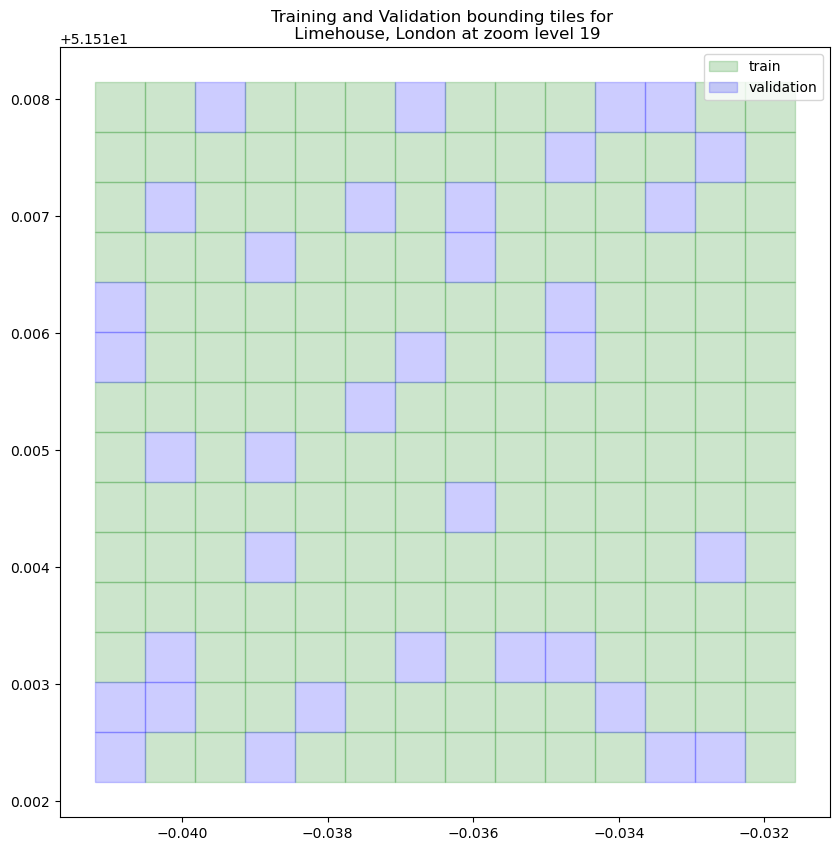

In [45]:
# Plot the bounding tiles
fig, ax = plt.subplots(figsize=(10, 10))
train_bounding_tiles.plot(ax=ax, color='green', edgecolor='green', alpha=0.2, label='train')
validation_bounding_tiles.plot(ax=ax, color='blue', edgecolor='blue', alpha=0.2, label='validation')

# Create legend patches
train_patch = patches.Patch(color='green', alpha=0.2, label='train')
validation_patch = patches.Patch(color='blue', alpha=0.2, label='validation')

# Add a legend and title
ax.legend(handles=[train_patch, validation_patch])
ax.set_title(f'Training and Validation bounding tiles for \n Limehouse, London at zoom level {ZOOM_LEVEL}')

plt.show()

Next we will convert the `id` column to a tuple of `x`, `y`, and `z` coorindates. These are the slippy map tile coordinates which we will use to download the satellite images.

In [46]:
import ast

# Convert the id column from a string into a type of integers
bounding_tiles['id'] = bounding_tiles['id'].apply(lambda x: ast.literal_eval(x))

# Rename the id column to coordinates
bounding_tiles.rename(columns={'id': 'coordinates'}, inplace=True)

bounding_tiles.head()

,coordinates,title,geometry,dataset
0,"(262084, 174314, 19)","XYZ tile (262084, 174314, 19)","POLYGON ((-0.04120 51.51772, -0.04120 51.51814...",train
1,"(262085, 174314, 19)","XYZ tile (262085, 174314, 19)","POLYGON ((-0.04051 51.51772, -0.04051 51.51814...",train
2,"(262086, 174314, 19)","XYZ tile (262086, 174314, 19)","POLYGON ((-0.03983 51.51772, -0.03983 51.51814...",validation
3,"(262087, 174314, 19)","XYZ tile (262087, 174314, 19)","POLYGON ((-0.03914 51.51772, -0.03914 51.51814...",train
4,"(262088, 174314, 19)","XYZ tile (262088, 174314, 19)","POLYGON ((-0.03845 51.51772, -0.03845 51.51814...",train


## Request satellite images from Mapbox API
Using Mapbox Raster Tiles API we can download satellite images for our training data using the [Slippy map tilenames](https://wiki.openstreetmap.org/wiki/Slippy_map_tilenames). The convention is as follows:
- Tiles are 256 × 256 pixel PNG files
- Each zoom level is a directory, each column is a subdirectory, and each tile in that column is a file
- Filename(url) format is /zoom/x/y.png
- The slippy map expects tiles to be served up at URLs following this scheme, so all tile server URLs look pretty similar.

We have the coordinates for each tile in the `coorindates` column of the `bounding_tiles` GeoDataFrame. We can use these to programmatically make GET requests to the Mapbox API to download the corresponding satellite images.

Take the first entry in the `bounding_tiles` GeoDataFrame. The tuple (262084, 174314, 19) in the `coordinates` column is a representation of the tile's coordinates in the XYZ tile scheme. This scheme is commonly used in web mapping applications for serving raster or vector tile images.

X (262084) and Y (174314) are the column and row of the tile in the grid for the given zoom level.
Z (19) is the zoom level. Higher numbers mean more detail.

The `geometry` column contains a `POLYGON` object which is the geographical boundaries of the tile. It's defined by a series of longitude and latitude coordinates that form a closed shape. We will later use this to crop the OSM building footprints within each of the tile boundaries.

In [65]:
# Print the number of tiles we have and therefore the number of requests
print(f'Number of image requests: {len(bounding_tiles)}')

# Create a function to download the images and masks
def download_tile_image(coordinates: Tuple[int], dataset: str, tile_size: int, mapbox_api_url: str, bearer_token:str):
    """
    Make a GET request to download the tile image from Mapbox API using the tile coordinates

    Args:
        coordinates (Tuple[int]): The tile coordinates
        dataset (str): The dataset (train or validation)
        tile_size (int): The image size of the tile
        mapbox_api_url (str): The Mapbox API url
        bearer_token (str): The Mapbox API bearer token

    Returns:
        image_path (Path): The image path
    """
    x, y, z = coordinates

    # Create the url to download the image
    url = f'{mapbox_api_url}/{z}/{x}/{y}@2x.png?access_token={bearer_token}'
    print(url)

    # Create the image path
    image_path = IMAGE_PATH / f's{tile_size}_z{z}' / dataset / f'{x}_{y}_{z}.png'

    # Download the image
    response = requests.get(url, stream=True)

    # Save the image
    with open(image_path, 'wb') as file:
        shutil.copyfileobj(response.raw, file)

    # Delete the response object
    del response

    return image_path

Number of image requests: 196


In [66]:
# Make a request for just one image
first_tile = bounding_tiles.iloc[0]
download_tile_image(coordinates=first_tile['coordinates'],
                    dataset=first_tile['dataset'],
                    tile_size=TILE_SIZE,
                    mapbox_api_url=os.getenv('MAPBOX_API_URL'),
                    bearer_token=os.getenv('MAPBOX_BEARER_TOKEN'))

https://api.mapbox.com/v4/mapbox.satellite/19/262084/174314@2x.png?access_token=pk.eyJ1IjoiaGFycmlzb25raW5nIiwiYSI6ImNrbnEyOWJweTAwejQzM250ajlzNWNxdHIifQ.hO_aPqm8-L_SqpcYRbeEbw


WindowsPath('data/london/images/s512_z19/train/262084_174314_19.png')